## Importing libraries

In [6]:
# Input and Output from Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# System Identification with Deep Learning

## Get the data

In [7]:
# Generate input - output data

def generate_xt(num_samples=10):
    x = np.random.uniform(-1, 1, num_samples) # Input random
    # x = np.random.randint(-100, 100, num_samples) # Input random
    t = np.zeros(num_samples)
    
    t[0] = 0   # Inisialisasi
    
    for k in range(1, num_samples):
        t[k] = 1 / (1 + t[k-1]**2) + 0.25*x[k] - 0.3*x[k-1]
    
    df = pd.DataFrame({"x": x, "t": t})
    return df

df = generate_xt(30002)
print(df)

              x         t
0     -0.664714  0.000000
1     -0.072628  1.181257
2     -0.218975  0.384517
3      0.283233  1.007692
4     -0.220060  0.356184
...         ...       ...
29997  0.836964  0.635655
29998  0.300729  0.536315
29999 -0.827688  0.479478
30000  0.794974  1.260125
30001  0.916332  0.377002

[30002 rows x 2 columns]


In [8]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t-1)" : df["t"].shift(1),
    "t(t-2)" : df["t"].shift(2),
    "t(t)"   : df["t"]   # target
})  # 3 lagged inputs and 2 lagged outputs

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       x(t)    x(t-1)    x(t-2)    t(t-1)    t(t-2)      t(t)
0 -0.218975 -0.072628 -0.664714  1.181257  0.000000  0.384517
1  0.283233 -0.218975 -0.072628  0.384517  1.181257  1.007692
2 -0.220060  0.283233 -0.218975  1.007692  0.384517  0.356184
3 -0.990171 -0.220060  0.283233  0.356184  1.007692  0.705892
4 -0.716943 -0.990171 -0.220060  0.705892  0.356184  0.785246
(30000, 6)


In [9]:
# dataset
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)", "t(t-1)", "t(t-2)"]].values   # input size=6
T = df_lagged[["t(t)"]].values    # target

# check size of dataset
print(X.shape, T.shape)

(30000, 5) (30000, 1)


## Splitting the dataset

In [10]:
def split_dataset_seq(X, T):
    """
    Membagi dataset 30.000 sample secara berurutan:
    - Train: 15.000 pertama
    - Val: 5.000 terakhir dari train + 5.000 setelah train
    - Test: 10.000 terakhir
    """
    assert len(X) == len(T), "Jumlah X dan T harus sama"
    assert len(X) == 30000, "Dataset harus 30.000 sample sesuai aturan"

    # Train 15.000 pertama
    X_train = X[:15000]
    T_train = T[:15000]

    # Validation = 5000 terakhir train + 5000 setelah train
    X_val = np.concatenate([X[10000:15000], X[15000:20000]])
    T_val = np.concatenate([T[10000:15000], T[15000:20000]])

    # Test = 10000 terakhir
    X_test = X[20000:]
    T_test = T[20000:]

    return X_train, T_train, X_val, T_val, X_test, T_test

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)


Train: (15000, 5) (15000, 1)
Val  : (10000, 5) (10000, 1)
Test : (10000, 5) (10000, 1)


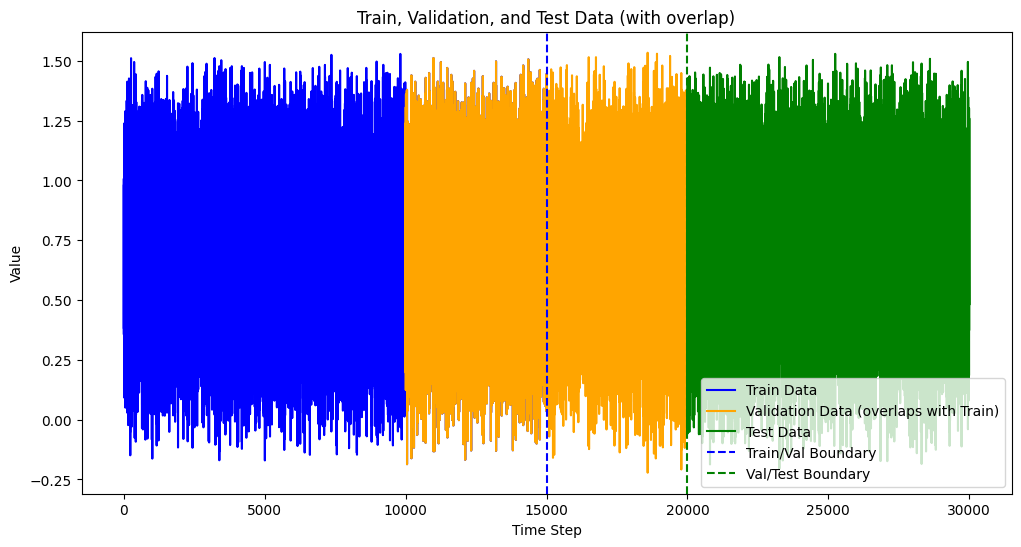

In [16]:
plt.figure(figsize=(12, 6))

# Define your index ranges explicitly
train_start, train_end = 0, 15000
val_start, val_end = 10000, 20000
test_start = 20000
test_end = test_start + len(T_test)

# Plot each segment with its corresponding x range
plt.plot(range(train_start, train_end), T_train, label='Train Data', color='blue')
plt.plot(range(val_start, val_end), T_val, label='Validation Data (overlaps with Train)', color='orange')
plt.plot(range(test_start, test_end), T_test, label='Test Data', color='green')

# Add vertical lines to indicate approximate boundaries
plt.axvline(x=train_end, color='b', linestyle='--', label='Train/Val Boundary')
plt.axvline(x=val_end, color='g', linestyle='--', label='Val/Test Boundary')

plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Train, Validation, and Test Data (with overlap)")

plt.show()

In [51]:
def normalize2(X_train, X_test=None, X_val=None):
    min_train = X_train.min(axis=0)     # minimum value for each feature
    max_train = X_train.max(axis=0)     # maximum value for each feature
    X_train_norm = 2  * (X_train - min_train) / (max_train - min_train) - 1
    
    X_val_norm = None
    if X_val is not None:
        X_val_norm = 2 * (X_val - min_train) / (max_train - min_train) - 1 if X_val is not None else None
    
    X_test_norm = None
    if X_test is not None:
        X_test_norm = 2 * (X_test - min_train) / (max_train - min_train) - 1 if X_test is not None else None
    
    return X_train_norm, X_val_norm, X_test_norm

# if using bipolar sigmoid activation, use scale [-1, 1]
X_train_norm, X_val_norm, X_test_norm = normalize2(X_train, X_test=X_test, X_val=X_val)
T_train_norm, T_val_norm, T_test_norm = normalize2(T_train, X_test=T_test, X_val=T_val)

print(X_train_norm)

[[-0.72390221  0.31197251  0.07573962]
 [-0.45367806 -0.72390221  0.31197251]
 [ 0.84119064 -0.45367806 -0.72390221]
 ...
 [-0.49378673  0.2564368   0.77807353]
 [-0.30785793 -0.49378673  0.2564368 ]
 [-0.08429097 -0.30785793 -0.49378673]]


## Neural Network Model

In [ ]:
from keras.models import Sequential             # Create all the layers
from keras.layers import Dense                  # Fully-connected layer

# create MLP model
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error')

C:\Users\putin\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training and Validation

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint  # Early stopping and monitor errors

# Path to save best weight
bestWeightPath = "bestWeight.weights.h5"

# Checkpoint to monitor errors
checkpoint = ModelCheckpoint(bestWeightPath, 
                             monitor='val_loss', # Monitor validation loss
                             verbose=1, 
                             save_best_only=True, # Save best weight
                             mode='min') # Loss as small as possible

# For early stopping
early_stopping_criteria = EarlyStopping(patience=5)

# List for callbacks
callbacks_list = [early_stopping_criteria, checkpoint]

# Training
history = model.fit(X_train, T_train, 
                    epochs = 100,
                    validation_data = (X_val, T_val),
                    callbacks=callbacks_list)

Epoch 1/100
449/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1982
Epoch 1: val_loss improved from inf to 0.00056, saving model to bestWeight.weights.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1921 - val_loss: 5.5739e-04
Epoch 2/100
447/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3041e-04
Epoch 2: val_loss improved from 0.00056 to 0.00034, saving model to bestWeight.weights.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.2781e-04 - val_loss: 3.4178e-04
Epoch 3/100
448/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3426e-04
Epoch 3: val_loss improved from 0.00034 to 0.00031, saving model to bestWeight.weights.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3316e-04 - val_loss: 3.1335e-04
Epoch 4/100
459/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4392e-04
Epoch 4: val_loss improved from 0.00031 to 0.00015, saving model to bestWeight.weights.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.4338e-04 - val_loss: 1.4821e-04
Epoch 5/100
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7906e-04
Epoch 5: val_loss did not improve from 0.00015
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7900e-04 - val_loss: 1.6112e-04
Epoch 6/100
451/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4712e-04
Epoch 6: val_loss improved from 0.00015 to 0.00005, saving model to bestWeight.weights.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4704e-04 - val_loss: 5.4864e-05
Epoch 7/100
448/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3455e-04
Epoch 7: val_loss did not improve from 0.00005
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3443e-04 - val_loss: 2.4515e-04
Epoch 8/100
458/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2310e-04
Epoch 8: val_loss did not improve from 0.00005
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2305e-04 - val_loss: 9.5130e-05
Epoch 9/100
430/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1648e-04
Epoch 9: val_loss improved from 0.00005 to 0.00004, saving model to bestWeight.weights.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1644e-04 - val_loss: 4.3655e-05
Epoch 10/100
451/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1240e-04
Epoch 10: val_loss improved from 0.00004 to 0.00004, saving model to bestWeight.weights.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1232e-04 - val_loss: 4.1954e-05
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0596e-04
Epoch 11: val_loss did not improve from 0.00004
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0596e-04 - val_loss: 6.1907e-05
Epoch 12/100
457/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0002e-04
Epoch 12: val_loss did not improve from 0.00004
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0010e-04 - val_loss: 8.1665e-05
Epoch 13/100
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0101e-04
Epoch 13: val_loss did not improve from 0.00004
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0098e-04 - val_loss: 4.2969e-05
Epoch 14/100
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6246e-05
Epoch 14: val_loss did not improve from 0.00004
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.6246e-05 - val_loss: 9.3659e-05
Epoch 15/100
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2661e-05
Epoch 15: val_loss did not i

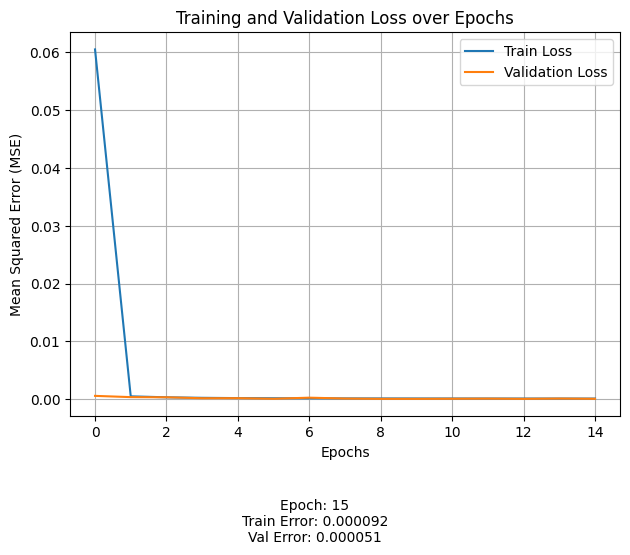

In [20]:
# training validation loss plot
# get the data
train_losses = history.history["loss"]
val_losses = history.history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

## Prediction from System Identification

In [22]:
prediction = model.predict(X_test)
print(prediction)

# I'm gonna use my library to calculate MSE here
from MyKeras.losses import mse
mse_test = mse(prediction.flatten(), T_test)
print("Test MSE:", mse_test)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
[[0.97647005]
 [0.6884373 ]
 [0.48536915]
 ...
 [0.47520107]
 [1.251188  ]
 [0.36398923]]
Test MSE: 0.22579146555682555


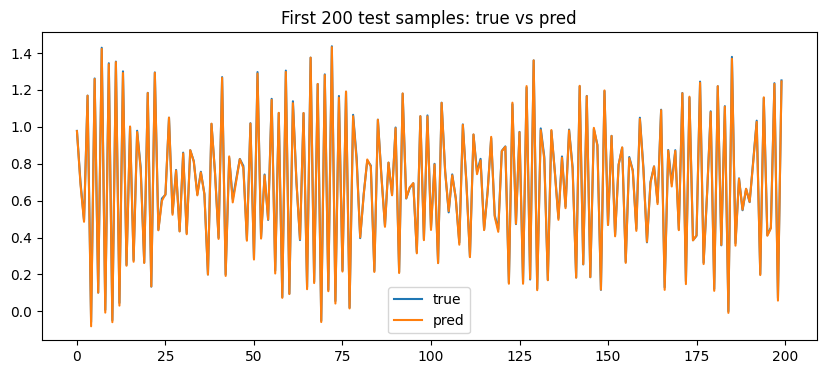

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
n = 200
y_pred = prediction.flatten()

plt.figure(figsize=(10,4))
plt.plot(T_test[:n], label='true')
plt.plot(y_pred[:n], label='pred')
plt.legend(); plt.title("First 200 test samples: true vs pred")
plt.show()

# Residuals
res = (T_test - y_pred).squeeze()
plt.figure(figsize=(6,3))
plt.hist(res, bins=80)
plt.title("Residuals histogram (test)")
plt.show()


# Control with NARX-NN

## Getting the Data

In [55]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t)"   : df["t"]   # target
})  # 3 lagged inputs and 2 lagged outputs

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       x(t)    x(t-1)    x(t-2)      t(t)
0 -0.723861  0.311985  0.075758  0.198568
1 -0.453645 -0.723861  0.311985  1.065814
2  0.841188 -0.453645 -0.723861  0.814564
3 -0.775866  0.841188 -0.453645  0.154814
4  0.423603 -0.775866  0.841188  1.315254
(30000, 4)


## Splitting the dataset

In [56]:
# dataset
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)"]].values   # 100 sampel, input size=6
T = df_lagged[["t(t)"]].values    # target

# check size of dataset
print(X.shape, T.shape)

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)

(30000, 3) (30000, 1)
Train: (15000, 3) (15000, 1)
Val  : (5000, 3) (5000, 1)
Test : (10000, 3) (10000, 1)


In [57]:
X_train_norm, X_val_norm, X_test_norm = normalize2(X_train, X_test=X_test, X_val=X_val)
T_train_norm, T_val_norm, T_test_norm = normalize2(T_train, X_test=T_test, X_val=T_val)

## Training and validation

In [58]:
# NARX model should be the same as MLP model defined earlier
y_lags = 2
model2 = NARX_NN()
model2.add(Dense(units=16, activation='relu', input_shape=X_train_norm.shape[1]+y_lags))
model2.add(Dense(units=8, activation='relu'))
model2.add(Dense(units=1))
model2.compile(loss='mean_squared_error', lr=0.01)
model2.set_weights(weights)
early_stopping_criteria = EarlyStopping(patience=10, restore_best_weights=True)
history = model2.fit(X_train_norm, T_train_norm, X_val_norm, T_val_norm, epochs=200, tol=1e-5, callbacks=[early_stopping_criteria])
# history = model2.fit(X_train, T_train, X_val, T_val, y_lags=y_lags, epochs=1000, tol=1e-6)

print("Last train loss:", history["train_loss"][-1])
print("Last val loss  :", history["val_loss"][-1])

[INFO] Adjusting layer 0 weight shape from (3, 16) to (5, 16)
Epoch 1: train_loss=0.012852, val_loss=0.000507
Epoch 10: train_loss=0.000102, val_loss=0.000101
Epoch 20: train_loss=0.000037, val_loss=0.000035
Epoch 30: train_loss=0.000022, val_loss=0.000020
Epoch 40: train_loss=0.000017, val_loss=0.000014
Epoch 50: train_loss=0.000014, val_loss=0.000011
Epoch 60: train_loss=0.000013, val_loss=0.000009
Epoch 70: train_loss=0.000012, val_loss=0.000008
Epoch 80: train_loss=0.000011, val_loss=0.000007
Epoch 90: train_loss=0.000011, val_loss=0.000007
Epoch 100: train_loss=0.000010, val_loss=0.000006
Epoch 110: train_loss=0.000010, val_loss=0.000006
Training stopped at epoch 116, train_loss=0.000010
Last train loss: 9.998462225327525e-06
Last val loss  : 5.591155922195354e-06


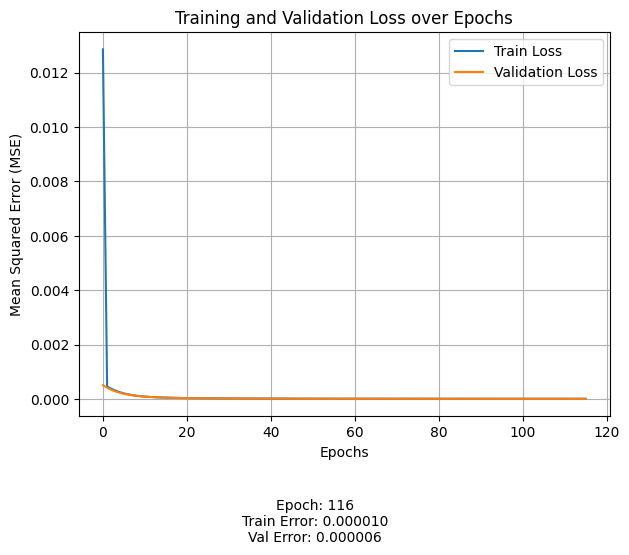

In [60]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]
last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [61]:
from MyKeras.losses import mse

# testing
predictions = model2.predict(X_test_norm)
# mse_test = mse(predictions, T_test)

# print("Predictions:", predictions.flatten())
# print("Test MSE:", mse_test)

In [ ]:
def rescale(T_norm, T_train):
    min_train = T_train.min(axis=0)
    max_train = T_train.max(axis=0)
    # inverse of normalize2
    Y_orig = 0.5 * (T_norm + 1) * (max_train - min_train) + min_train
    return Y_orig

ypred = rescale(predictions, T_train)

mse_test = mse(ypred, T_test)

print("Predictions:", predictions.flatten())
print("Test MSE:", mse_test)


Predictions: [ 0.1706206   0.43460878 -0.14927506 ...  0.13504328  0.53215576
 -0.34182814]
Test MSE: 0.1760889238426926


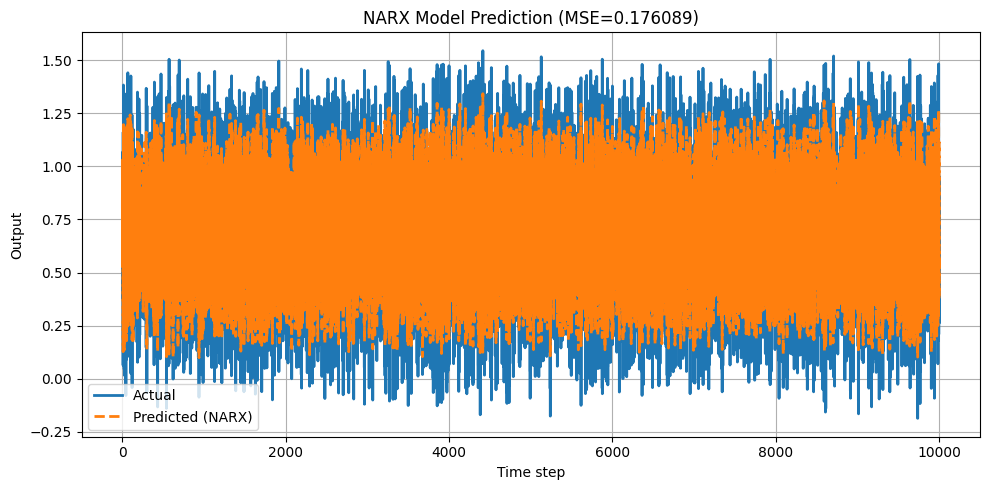

In [64]:
# --- prediction vs target plot ---
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(ypred.flatten(), label='Predicted (NARX)', linestyle='--', linewidth=2)
plt.title(f'NARX Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()